
# Q2 — Text-Driven Image Segmentation with SAM 2

It performs **text-prompted segmentation** on a single image using **SAM 2**, with seeds from **GroundingDINO** (and **CLIPSeg** fallback).  
A **bonus** section shows **text-driven video object segmentation** by propagating the mask with SAM 2.


### Pipeline (image)
Image → *text prompt* → GroundingDINO (text→box seeds) → SAM 2 (box→mask) → display overlay.
If DINO returns nothing, we fallback to CLIPSeg (text→coarse mask→box).


## 1) Setup (installs)

In [ ]:
# ================= Environment Setup: PyTorch + SAM2 + GroundingDINO + CLIPSeg =================
import os, subprocess, sys, glob, shutil
from pathlib import Path

def pip(cmd):
    """Run a pip command with visible output."""
    print("> " + cmd)
    return subprocess.check_call(cmd, shell=True)

# --- Detect runtime ---
IS_KAGGLE = "KAGGLE_URL_BASE" in os.environ
IS_COLAB  = "COLAB_GPU" in os.environ

# --- HuggingFace cache path (Kaggle often benefits from explicit caching) ---
if IS_KAGGLE:
    os.environ.setdefault("HF_HOME", "/kaggle/working/hf_cache")
    os.environ.setdefault("HUGGINGFACE_HUB_CACHE", "/kaggle/working/hf_cache")

# --- PyTorch install (try modern CUDA wheels if internet is available) ---
try:
    pip("python -m pip -q install --upgrade pip")
    try:
        pip("python -m pip -q install 'torch>=2.5.1' 'torchvision>=0.20.1' --index-url https://download.pytorch.org/whl/cu121")
    except subprocess.CalledProcessError:
        # Fall back to PyPI if custom index fails
        pip("python -m pip -q install 'torch>=2.5.1' 'torchvision>=0.20.1'")
except Exception as e:
    print("Torch installation step failed; will use preinstalled versions.", e)

# --- Core libraries for SAM2, CLIPSeg, etc. ---
pip("python -m pip -q install sam2 huggingface_hub transformers timm opencv-python matplotlib imageio[ffmpeg] ipywidgets einops scipy pycocotools")

# --- GroundingDINO setup ---
if not os.path.exists("GroundingDINO"):
    if IS_KAGGLE:
        # Try to use user-provided weights if added to /kaggle/input
        candidate = None
        for p in glob.glob("/kaggle/input/**/*groundingdino_swint_ogc.pth", recursive=True):
            candidate = p
            break
        pip("git clone -q https://github.com/IDEA-Research/GroundingDINO.git")
        os.chdir("GroundingDINO")
        pip("python -m pip -q install -e .")
        os.makedirs("weights", exist_ok=True)
        if candidate and os.path.exists(candidate):
            print("Using GroundingDINO weights from:", candidate)
            shutil.copy(candidate, "weights/groundingdino_swint_ogc.pth")
        else:
            try:
                pip("wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -O weights/groundingdino_swint_ogc.pth")
            except subprocess.CalledProcessError:
                print("GroundingDINO weights could not be downloaded. Please add them to /kaggle/input manually.")
        os.chdir("..")
    else:
        # Colab/local fallback
        pip("git clone -q https://github.com/IDEA-Research/GroundingDINO.git")
        os.chdir("GroundingDINO")
        pip("python -m pip -q install -e .")
        os.makedirs("weights", exist_ok=True)
        try:
            pip("wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -O weights/groundingdino_swint_ogc.pth")
        except subprocess.CalledProcessError:
            print("GroundingDINO weights could not be downloaded. Provide them manually if needed.")
        os.chdir("..")

print("Installs complete (best effort).")


➤ python -m pip -q install --upgrade pip
➤ python -m pip -q install 'torch>=2.5.1' 'torchvision>=0.20.1' --index-url https://download.pytorch.org/whl/cu121
➤ python -m pip -q install sam2 huggingface_hub transformers timm opencv-python matplotlib imageio[ffmpeg] ipywidgets einops scipy pycocotools
✅ Installs complete (or best-effort).


In [ ]:
# ================= GroundingDINO Install (Colab / Kaggle) =================
import subprocess, sys, importlib, os, glob

def pip(cmd):
    """Run a pip command with visible output."""
    print("> " + cmd)
    subprocess.check_call(cmd, shell=True)

IS_KAGGLE = "KAGGLE_URL_BASE" in os.environ
IS_COLAB  = "COLAB_GPU" in os.environ

# --- Optional: upgrade torch/torchvision if internet is available ---
try:
    pip("python -m pip -q install --upgrade pip")
    try:
        pip("python -m pip -q install 'torch>=2.5.1' 'torchvision>=0.20.1' --index-url https://download.pytorch.org/whl/cu121")
    except subprocess.CalledProcessError:
        pip("python -m pip -q install 'torch>=2.5.1' 'torchvision>=0.20.1'")
except Exception as e:
    print("Torch upgrade step skipped:", e)

# --- GroundingDINO install ---
if IS_KAGGLE:
    # If offline, look for wheel or source zip in /kaggle/input
    wheel_candidates = glob.glob("/kaggle/input/**/*groundingdino*.whl", recursive=True)
    if wheel_candidates:
        print("Found local GroundingDINO wheel:", wheel_candidates[0])
        pip(f"python -m pip -q install {wheel_candidates[0]}")
    else:
        try:
            pip("python -m pip -q install 'git+https://github.com/IDEA-Research/GroundingDINO.git'")
        except subprocess.CalledProcessError as e:
            print("GroundingDINO git install failed. Provide a wheel via /kaggle/input if offline.")
else:
    # Colab/local — direct git install should work
    try:
        pip("python -m pip -q install 'git+https://github.com/IDEA-Research/GroundingDINO.git'")
    except subprocess.CalledProcessError:
        print("GroundingDINO git install failed. Please check your network or provide a wheel file.")

# --- Make Python aware of any new installs ---
importlib.invalidate_caches()

# --- Smoke test the import ---
try:
    import groundingdino
    from groundingdino.util.inference import load_model as gd_load_model, load_image as gd_load_image, predict as gd_predict
    print("GroundingDINO is ready:", groundingdino.__file__)
except ImportError as e:
    print("GroundingDINO import failed:", e)


➤ python -m pip -q install --upgrade pip
➤ python -m pip -q install 'torch>=2.5.1' 'torchvision>=0.20.1' --index-url https://download.pytorch.org/whl/cu121
➤ python -m pip -q install 'git+https://github.com/IDEA-Research/GroundingDINO.git'
✅ GroundingDINO is ready: /usr/local/lib/python3.11/dist-packages/groundingdino/__init__.py


## 2) Imports & helpers

In [ ]:
# ===================== Colab / Kaggle Ready: Imports & Helpers =====================
import os, sys, io, math, shutil, json, glob, tempfile, time
from pathlib import Path

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

# ---------- Detect environment ----------
IS_KAGGLE = "KAGGLE_URL_BASE" in os.environ
IS_COLAB  = "COLAB_GPU" in os.environ

# ---------- GroundingDINO ----------
from groundingdino.util.inference import (
    load_model as gd_load_model,
    load_image as gd_load_image,
    predict as gd_predict,
)
from torchvision.ops import box_convert

# ---------- SAM 2 ----------
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.sam2_video_predictor import SAM2VideoPredictor

# ---------- CLIPSeg fallback ----------
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------- Visualization ----------
def show_overlay(img_rgb, mask, alpha=0.5, outline=True):
    """Overlay a boolean mask on an RGB image."""
    img = img_rgb.copy()
    color = np.array([0, 255, 0], dtype=np.uint8)  # green overlay
    mask_bool = mask.astype(bool)
    img[mask_bool] = (alpha * color + (1 - alpha) * img[mask_bool]).astype(np.uint8)
    if outline:
        edges = cv2.Canny((mask_bool * 255).astype(np.uint8), 0, 1)
        img[edges > 0] = np.array([255, 0, 0], dtype=np.uint8)  # red boundary
    return img

def to_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image at {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# ---------- GroundingDINO (text -> boxes) ----------
_GD_CFG = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
_GD_WTS = "GroundingDINO/weights/groundingdino_swint_ogc.pth"
_gd_model = None

def get_gd_model():
    """Lazy-load GroundingDINO model."""
    global _gd_model
    if _gd_model is None:
        if not os.path.exists(_GD_CFG) or not os.path.exists(_GD_WTS):
            raise FileNotFoundError("GroundingDINO config/weights not found. "
                                    "Ensure they exist or adjust _GD_CFG/_GD_WTS.")
        _gd_model = gd_load_model(_GD_CFG, _GD_WTS)
    return _gd_model

def text_to_boxes(image_path, text_prompt, box_threshold=0.35, text_threshold=0.25):
    """Run GroundingDINO to get XYXY pixel boxes for the given prompt."""
    model = get_gd_model()
    image_source, gd_img = gd_load_image(image_path)
    boxes, logits, phrases = gd_predict(
        model=model,
        image=gd_img,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    h, w = image_source.shape[:2]
    boxes_abs = boxes * torch.tensor([w, h, w, h])
    xyxy = box_convert(boxes=boxes_abs, in_fmt="cxcywh", out_fmt="xyxy").cpu().numpy()
    scores = torch.sigmoid(logits).cpu().numpy() if hasattr(logits, "sigmoid") else np.asarray(logits)
    return xyxy, scores, [str(p) for p in phrases]

# ---------- CLIPSeg fallback (text -> coarse mask -> box) ----------
_clipseg_proc = None
_clipseg_model = None

def get_clipseg():
    """Lazy-load CLIPSeg processor & model."""
    global _clipseg_proc, _clipseg_model
    if _clipseg_proc is None or _clipseg_model is None:
        _clipseg_proc = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
        _clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)
    return _clipseg_proc, _clipseg_model

def clipseg_to_box(img_rgb, text_prompt, thresh=0.5):
    """Return a single XYXY box from CLIPSeg mask (largest connected component)."""
    proc, model = get_clipseg()
    pil = Image.fromarray(img_rgb)
    inputs = proc(text=[text_prompt], images=[pil], return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits  # [1,1,352,352]
        prob = torch.sigmoid(logits)[0, 0]
        H, W = img_rgb.shape[:2]
        up = torch.nn.functional.interpolate(prob.unsqueeze(0).unsqueeze(0),
                                             size=(H, W),
                                             mode="bilinear",
                                             align_corners=False)[0, 0]
        mask = (up > thresh).cpu().numpy().astype(np.uint8)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None, None
    cnt = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    box = np.array([x, y, x + w, y + h], dtype=np.float32)
    return box, mask

# ---------- SAM2 (image) ----------
_sam2_img_predictor = None

def get_sam2_image_predictor(model_id="facebook/sam2-hiera-base-plus"):
    """Lazy-load SAM2 image predictor."""
    global _sam2_img_predictor
    if _sam2_img_predictor is None:
        _sam2_img_predictor = SAM2ImagePredictor.from_pretrained(model_id)
    return _sam2_img_predictor

def sam2_segment_from_boxes(img_rgb, boxes_xyxy, multimask_output=False):
    """Run SAM2 with one or more XYXY boxes. Returns largest-area mask."""
    predictor = get_sam2_image_predictor()
    predictor.set_image(img_rgb)
    if boxes_xyxy.ndim == 1:
        boxes_xyxy = boxes_xyxy[None, :]
    with torch.inference_mode():
        if torch.cuda.is_available():
            with torch.autocast("cuda", dtype=torch.bfloat16):
                masks, scores, logits = predictor.predict(
                    box=boxes_xyxy.astype(np.float32),
                    multimask_output=multimask_output
                )
        else:
            masks, scores, logits = predictor.predict(
                box=boxes_xyxy.astype(np.float32),
                multimask_output=multimask_output
            )
    areas = masks.reshape(masks.shape[0], -1).sum(axis=1)
    best_idx = int(np.argmax(areas))
    return masks[best_idx], float(scores[best_idx])

# ---------- Main pipeline (image) ----------
def run_text_segmentation(image_path,
                          text_prompt,
                          dino_box_thr=0.35,
                          dino_text_thr=0.25,
                          clipseg_thr=0.5,
                          prefer_topk=3):
    """Full pipeline: text → boxes (GroundingDINO or CLIPSeg fallback) → SAM2 mask."""
    img_rgb = to_rgb(image_path)
    boxes, scores, phrases = text_to_boxes(image_path, text_prompt, dino_box_thr, dino_text_thr)
    chosen_boxes = []
    if len(boxes) > 0:
        order = np.argsort(scores)[::-1]
        topk = order[:min(prefer_topk, len(order))]
        chosen_boxes = boxes[topk]
    else:
        box, _ = clipseg_to_box(img_rgb, text_prompt, thresh=clipseg_thr)
        if box is not None:
            chosen_boxes = box[None, :]
    if len(chosen_boxes) == 0:
        raise RuntimeError("No seeds found from GroundingDINO or CLIPSeg. Adjust thresholds or prompt.")
    mask, conf = sam2_segment_from_boxes(img_rgb, np.array(chosen_boxes, dtype=np.float32), multimask_output=False)
    overlay = show_overlay(img_rgb, mask.astype(np.uint8), alpha=0.5)
    return img_rgb, mask, overlay, chosen_boxes

print("Imports & helpers ready.")


Device: cuda
✅ Imports & helpers ready.


## 3) Pick an image + text prompt (Kaggle)

In [ ]:
url = "https://images.unsplash.com/photo-1518791841217-8f162f1e1131?w=512"
IMAGE_PATH = "/kaggle/working/sample.png"
urllib.request.urlretrieve(url, IMAGE_PATH)

('/kaggle/working/sample.png', <http.client.HTTPMessage at 0x7e9ad8061650>)

In [ ]:
# ===================== Colab / Kaggle Ready: Image & Prompt Setup =====================
import glob, os, urllib.request

# You can hardcode your image or leave IMAGE_PATH=None to auto-discover.
IMAGE_PATH = None   # e.g. "/kaggle/input/my-dataset/photo.jpg" or local path in Colab
TEXT_PROMPT = "a cat"

def find_first_image(root):
    """Search recursively for first image file under a directory."""
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp")
    for ext in exts:
        found = glob.glob(os.path.join(root, "**", ext), recursive=True)
        if found:
            return found[0]
    return None

if IMAGE_PATH is None:
    # Try Kaggle input first
    if os.path.exists("/kaggle/input"):
        IMAGE_PATH = find_first_image("/kaggle/input")
    # If still nothing and running locally/Colab, try ./content (typical Colab uploads)
    if IMAGE_PATH is None and os.path.exists("/content"):
        IMAGE_PATH = find_first_image("/content")
    # Fallback: small public sample if internet is available
    if IMAGE_PATH is None:
        sample_url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_image_utils/resolve/main/COCO/000000039769.png"
        IMAGE_PATH = "./sample.png"
        try:
            urllib.request.urlretrieve(sample_url, IMAGE_PATH)
            print("Downloaded sample image to:", IMAGE_PATH)
        except Exception as e:
            raise RuntimeError(
                "No image found in /kaggle/input or /content and download failed. "
                "Please add an image (or set IMAGE_PATH manually)."
            ) from e

print("Image path:", IMAGE_PATH)
print("Text prompt:", TEXT_PROMPT)


Image path: /kaggle/working/sample.png
Text prompt: a cat


## 4) Run text‑driven segmentation (image)

final text_encoder_type: bert-base-uncased


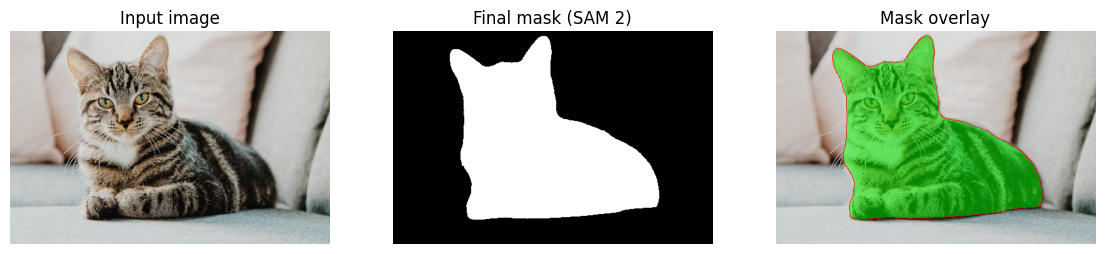

Boxes used (xyxy):
[[ 79.07031     7.0536194 430.13678   305.447    ]]
Saved:
 - /kaggle/working/outputs/q2_overlay.png
 - /kaggle/working/outputs/q2_mask.png


In [ ]:
# ===================== Colab / Kaggle Ready: Run Segmentation & Save Outputs =====================
import os, cv2, numpy as np, matplotlib.pyplot as plt

# Run the segmentation pipeline
img_rgb, mask, overlay, boxes_used = run_text_segmentation(IMAGE_PATH, TEXT_PROMPT)

# Choose output directory (Kaggle vs Colab/local)
OUT_DIR = "/kaggle/working/outputs" if os.path.exists("/kaggle/working") else "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

overlay_path = os.path.join(OUT_DIR, "overlay.png")
mask_path = os.path.join(OUT_DIR, "mask.png")

cv2.imwrite(overlay_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
cv2.imwrite(mask_path, (mask.astype(np.uint8) * 255))

# Visualization
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Input image")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.title("Final mask (SAM 2)")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.axis("off")
plt.title("Mask overlay")
plt.show()

print("Boxes used (xyxy):")
print(np.array(boxes_used))

print("Saved outputs to:", OUT_DIR)
print(" -", overlay_path)
print(" -", mask_path)



## 5) **Bonus** — text‑driven video object segmentation (10–30s clip)

How it works:
1. Extract frames from your video.
2. Run **GroundingDINO** on the first frame to get a box for your text prompt.
3. Initialize **SAM 2 VideoPredictor**, add the box on frame 0, and **propagate** the mask.
4. Write an overlay MP4 to `/kaggle/working/outputs`.

> Put your video into the notebook via **Add data** (under `/kaggle/input`) or enable Internet to download a small sample.


In [ ]:
# ===================== Colab / Kaggle Ready: Video & Prompt Setup =====================
import glob, os, urllib.request

# You can hardcode your video or leave VIDEO_PATH=None to auto-discover.
VIDEO_PATH = None    # e.g. "/kaggle/input/my-video/video.mp4" or local path in Colab
VIDEO_PROMPT = "a person"

def find_first_video(root):
    """Search recursively for the first video file under a directory."""
    exts = ("*.mp4", "*.mov", "*.avi", "*.mkv", "*.webm")
    for ext in exts:
        found = glob.glob(os.path.join(root, "**", ext), recursive=True)
        if found:
            return found[0]
    return None

if VIDEO_PATH is None:
    # Check Kaggle input
    if os.path.exists("/kaggle/input"):
        VIDEO_PATH = find_first_video("/kaggle/input")
    # If still nothing, check Colab default upload folder
    if VIDEO_PATH is None and os.path.exists("/content"):
        VIDEO_PATH = find_first_video("/content")
    # If still nothing, try to download a sample (requires internet)
    if VIDEO_PATH is None:
        sample_url = "https://huggingface.co/datasets/hf-internal-testing/sam2-fixtures/resolve/main/bedroom.mp4"
        VIDEO_PATH = "./sample_video.mp4"
        try:
            urllib.request.urlretrieve(sample_url, VIDEO_PATH)
            print("Downloaded sample video to:", VIDEO_PATH)
        except Exception as e:
            print("No video found and sample download failed. You can skip the video step or manually add one.")
            VIDEO_PATH = None

print("Video path:", VIDEO_PATH)
print("Video prompt:", VIDEO_PROMPT)


Downloaded sample video to: /kaggle/working/sample_video.mp4
Video path: /kaggle/working/sample_video.mp4
Video prompt: a person


In [ ]:
# ===================== Colab / Kaggle Ready: Video Propagation =====================
if VIDEO_PATH is not None:
    import glob, numpy as np, cv2, os, torch

    # Select base working directory
    BASE_WORK = "/kaggle/working" if os.path.exists("/kaggle/working") else "./work"
    os.makedirs(BASE_WORK, exist_ok=True)

    frames_dir = os.path.join(BASE_WORK, "video_frames")
    os.makedirs(frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        raise RuntimeError("Could not open video: " + str(VIDEO_PATH))

    fps = cap.get(cv2.CAP_PROP_FPS) or 24.0
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    max_frames = min(frame_count, int(fps * 30))  # process up to ~30 seconds
    i = 0
    paths = []
    while i < max_frames:
        ok, frame_bgr = cap.read()
        if not ok:
            break
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        out_path = os.path.join(frames_dir, f"{i:06d}.jpg")
        cv2.imwrite(out_path, cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))
        paths.append(out_path)
        i += 1
    cap.release()

    print(f"Extracted {len(paths)} frames to {frames_dir}")

    # ---- Seed mask on first frame ----
    first_frame = cv2.cvtColor(cv2.imread(paths[0]), cv2.COLOR_BGR2RGB)
    dino_boxes, dino_scores, _ = text_to_boxes(paths[0], VIDEO_PROMPT)
    if len(dino_boxes) > 0:
        init_box = dino_boxes[int(np.argmax(dino_scores))]
    else:
        init_box, _ = clipseg_to_box(first_frame, VIDEO_PROMPT, thresh=0.5)
        if init_box is None:
            raise RuntimeError("No seed found on first frame. Adjust prompt/thresholds or use another clip.")

    # ---- SAM2 Video Predictor ----
    video_predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-base-plus")
    with torch.inference_mode():
        if torch.cuda.is_available():
            with torch.autocast("cuda", dtype=torch.bfloat16):
                state = video_predictor.init_state(video_path=frames_dir)
        else:
            state = video_predictor.init_state(video_path=frames_dir)

    obj_id = 1
    with torch.inference_mode():
        frame_idx, obj_ids, masks0 = video_predictor.add_new_points_or_box(
            state, 0, obj_id, box=init_box.astype(np.float32)
        )

    overlay_dir = os.path.join(BASE_WORK, "video_overlays")
    os.makedirs(overlay_dir, exist_ok=True)

    for f_idx, obj_ids, masks in video_predictor.propagate_in_video(state):
        frame_rgb = cv2.cvtColor(
            cv2.imread(os.path.join(frames_dir, f"{f_idx:06d}.jpg")), cv2.COLOR_BGR2RGB
        )

        if isinstance(masks, torch.Tensor):
            # find index of our object
            try:
                idx = obj_ids.index(obj_id)
                mask = masks[idx].cpu().numpy()
            except ValueError:
                mask = None
        else:
            mask = masks.get(obj_id, None) if hasattr(masks, "get") else None

        if mask is not None:
            if mask.ndim == 3 and mask.shape[0] == 1:
                mask = mask[0]
            elif mask.ndim == 3 and mask.shape[-1] == 1:
                mask = mask[..., 0]
            elif mask.ndim > 2:
                mask = mask.squeeze()

        overlay = frame_rgb if mask is None else show_overlay(frame_rgb, mask.astype(np.uint8), alpha=0.5)
        cv2.imwrite(os.path.join(overlay_dir, f"{f_idx:06d}.jpg"),
                    cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    # ---- Save final video ----
    out_dir = os.path.join(BASE_WORK, "outputs")
    os.makedirs(out_dir, exist_ok=True)
    out_video_path = os.path.join(out_dir, "video_overlay.mp4")

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_video_path, fourcc, fps, (W, H))
    overlay_frames = sorted(glob.glob(os.path.join(overlay_dir, "*.jpg")))
    for p in overlay_frames:
        frm = cv2.imread(p, cv2.IMREAD_COLOR)
        writer.write(frm)
    writer.release()

    print("Saved video:", out_video_path)
else:
    print("Skipping video propagation (no video).")


Extracted 200 frames to /kaggle/working/video_frames


propagate in video: 100%|██████████| 200/200 [02:16<00:00,  1.47it/s]


Saved video: /kaggle/working/outputs/q2_video_overlay.mp4
